In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Define paths and parameters
data_path = r"C:\Users\LABKOM-12\Documents\saboy\eyepac-light-v2-512-jpg"
folders = ['train', 'validation', 'test']
classes = ['RG', 'NRG']  # RG = referable glaucoma, NRG = non-referable glaucoma
img_size = (128, 128)
batch_size = 32
epochs = 50

In [3]:
# 1. Display the number of datasets in each folder as a table with totals
data_counts = []

for folder in folders:
    for class_name in classes:
        path = os.path.join(data_path, folder, class_name)
        num_images = len(os.listdir(path))
        data_counts.append([folder, class_name, num_images])

df_counts = pd.DataFrame(data_counts, columns=["Folder", "Class", "Number of Images"])
pivot_table = df_counts.pivot(index="Class", columns="Folder", values="Number of Images")
pivot_table["Total"] = pivot_table.sum(axis=1)  # Add total per class
pivot_table.loc["Total"] = pivot_table.sum(axis=0)  # Add total per column
print(pivot_table)


Folder  test  train  validation  Total
Class                                 
NRG      385   4000         385   4770
RG       385   4000         385   4770
Total    770   8000         770   9540


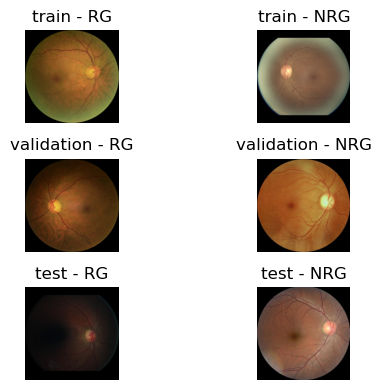

In [4]:
# === 2. Menampilkan contoh gambar dari setiap dataset ===
def show_sample_images():
    fig, axes = plt.subplots(len(folders), len(classes), figsize=(6, 4))
    for i, folder in enumerate(folders):
        for j, class_name in enumerate(classes):
            path = os.path.join(data_path, folder, class_name)
            image_name = os.listdir(path)[0]
            image_path = os.path.join(path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"{folder} - {class_name}")
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images()

In [5]:
# Fungsi untuk memuat dan memproses gambar
def load_images_and_labels(folder_path):
    images = []
    labels = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                # Resize gambar
                image = cv2.resize(image, (128, 128))
                
                # Preprocessing: CLAHE
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                clahe_img = clahe.apply(gray)

                # Normalisasi dan reshape
                clahe_img = clahe_img.astype('float32') / 255.0
                images.append(clahe_img)
                labels.append(class_name)
    
    return np.array(images), np.array(labels)


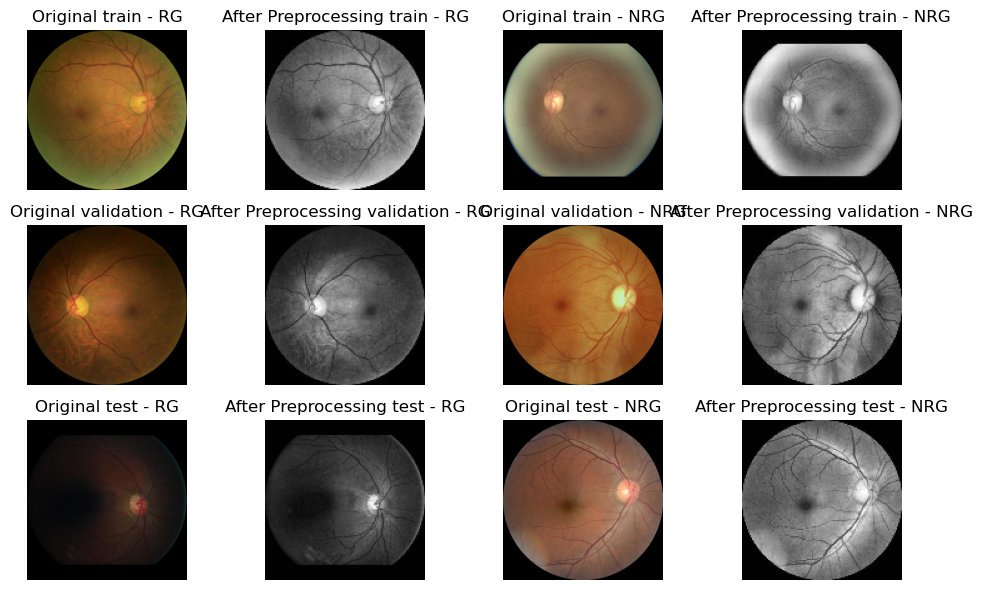

In [6]:
# Fungsi untuk menampilkan hasil preprocessing
def show_preprocessing_example():
    fig, axes = plt.subplots(len(folders), len(classes) * 2, figsize=(10, 6))

    for i, folder in enumerate(folders):
        for j, class_name in enumerate(classes):
            path = os.path.join(data_path, folder, class_name)
            image_name = os.listdir(path)[0]
            image_path = os.path.join(path, image_name)

            # Baca gambar asli
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Tampilkan gambar asli sebelum preprocessing
            axes[i, j * 2].imshow(image)
            axes[i, j * 2].set_title(f"Original {folder} - {class_name}")
            axes[i, j * 2].axis("off")
            
            # Terapkan preprocessing
            processed_image = cv2.resize(image, (128, 128))
            processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            processed_image = clahe.apply(processed_image)
            processed_image = processed_image.astype('float32') / 255.0
            
            # Tampilkan gambar setelah preprocessing
            axes[i, j * 2 + 1].imshow(processed_image, cmap='gray')
            axes[i, j * 2 + 1].set_title(f"After Preprocessing {folder} - {class_name}")
            axes[i, j * 2 + 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Tampilkan contoh preprocessing
show_preprocessing_example()

In [7]:
# Muat dan proses semua dataset
X_train, y_train = load_images_and_labels(os.path.join(data_path, 'train'))
X_test, y_test = load_images_and_labels(os.path.join(data_path, 'test'))
X_val, y_val = load_images_and_labels(os.path.join(data_path, 'validation'))

# Binarisasi label
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

# Reshape gambar untuk input model
X_train = X_train.reshape(-1, 128, 128, 1)  # Menambahkan dimensi untuk channel
X_test = X_test.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

In [8]:
# Define Self-ONN model (simplified version based on the paper)
def create_self_onn(input_shape, Q=5):
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (11, 11), activation='tanh', input_shape=input_shape))
    model.add(MaxPooling2D((4, 4)))
    # Layer 2
    model.add(Conv2D(16, (9, 9), activation='tanh'))
    model.add(MaxPooling2D((4, 4)))
    # Layer 3
    model.add(Conv2D(8, (3, 3), activation='tanh'))
    model.add(MaxPooling2D((2, 2)))
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(16, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    return model

# Create model
input_shape = (128, 128, 1)
Q = 5  # Order of Maclaurin approximation
model = create_self_onn(input_shape, Q)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\LABKOM-12\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Latih model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5112 - loss: 0.7145 - val_accuracy: 0.6662 - val_loss: 0.6601
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5990 - loss: 0.6637 - val_accuracy: 0.6974 - val_loss: 0.5968
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6457 - loss: 0.6254 - val_accuracy: 0.7195 - val_loss: 0.5582
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6947 - loss: 0.5877 - val_accuracy: 0.7078 - val_loss: 0.5620
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7233 - loss: 0.5619 - val_accuracy: 0.7351 - val_loss: 0.5293
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7300 - loss: 0.5480 - val_accuracy: 0.7636 - val_loss: 0.4961
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7597 - loss: 0.5042 - val_accuracy: 0.7662 - val_loss: 0.4961
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7728 - loss: 0.4884 - val_acc

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Accuracy: 0.8416
Precision: 0.8346
Recall (Sensitivity): 0.8519
F1-Score: 0.8432
Confusion Matrix:
[[320  65]
 [ 57 328]]


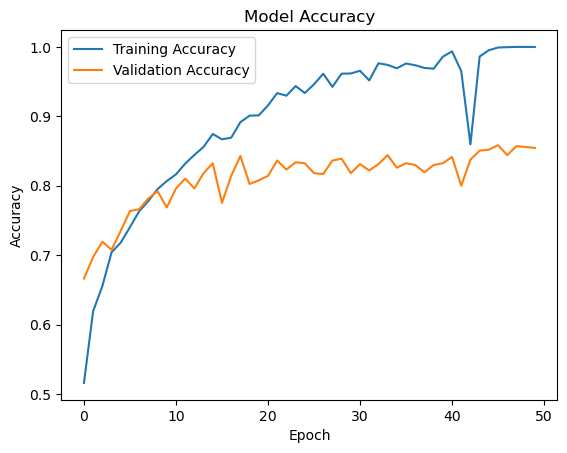

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
model.save('C:/Users/LABKOM-12/Documents/saboy/SKRIPSI/model.keras')
print("Model disimpan di:", 'path/to/your/model.keras')
